# Modeling Transcription in the iJL1678b (ECOLIme) Model

## 1. Load the python packages

In [1]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',100)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## 2. Load the iJL1678b model

Load the iJL1678b model in pickle format that is located in the current directory.

In [2]:
with open('iJL1678b.pickle', 'rb') as f:
    me = pickle.load(f)

## 3. Solve the model

In [3]:
def solve_me_model(me, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(me, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(me, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        me.solution.f = me.solution.x_dict['biomass_dilution']
        
def show_escher_map(me, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = me.get_metabolic_flux(solution=solution)
    return view

In [4]:
solve_me_model(me, 1., min_mu = .1, precision=1e-2, using_soplex=False)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 80.953501 seconds
Finished substituting S,lb,ub in 5.583061 seconds
Finished makeME_LP in 0.890268 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 5.986166 seconds
Finished makeME_LP in 0.912409 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 5.719774 seconds
Finished makeME_LP in 0.864543 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 5.248134 seconds
Finished makeME_LP in 0.867115 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 5.322925 seconds
Finished makeME_LP in 0.846991 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 5.150598 seconds
Finished makeME_LP in 0.830167 seconds
Getting MINOS pa

## 4. Modeling the iJL1678b-ME (ECOLIme) Transcription Process

A “TranscriptionReaction” includes all the metabolites required to transcribe the DNA associated with a specific EcoCyc defined transcription unit to either RNA or mRNA. A graphical overview of this reaction is shown below.

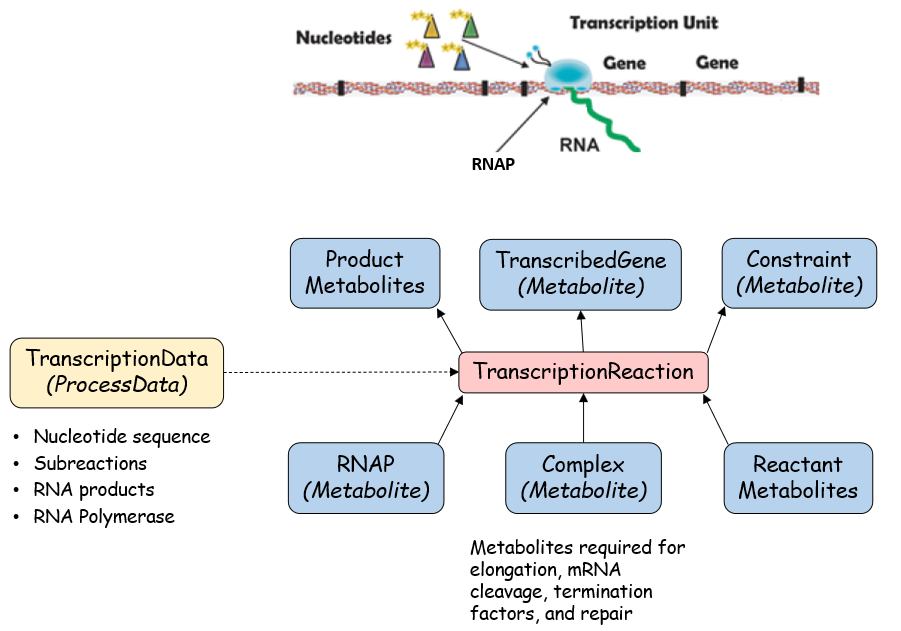

The reactant metabolites include:

- The nucleotide metabolites required for the reaction (derived from the nucleotide sequence located in the “processdata” class)
- The metabolites required for transcription elongation
- The metabolites required for transcription repair
- The RNA polymerase and associated metabolites
- The termination factor metabolites
- The metabolites required for mRNA cleavage

Let's start by creating a table that lists all the transcription reactions in the model and their RNA products.

In [5]:
model_transcription_reactions = []
RNA_products = []
temp = []
x = [r.id for r in me.reactions]
for r in x:
    # Find transcription reactions
    if 'transcription_T' in r: 
        model_transcription_reactions.append(r)
        y = [r.id for r in me.reactions.get_by_id(r).products]
        # Find RNA in transcription reaction products
        for z in y: 
            if "RNA_b" in z and "biomass" not in z:
                temp.append(z)
        RNA_products.append(temp)
        temp = []

# Create Pandas table
zipped = list(zip(model_transcription_reactions, RNA_products))
df = pd.DataFrame(zipped, columns=['Transcription Reactions', 'RNA Products']).set_index('Transcription Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,RNA Products
Transcription Reactions,
transcription_TU0_13350_from_RpoD_mono,[RNA_b1623]
transcription_TU0_7622_from_RpoD_mono,"[RNA_b0517, RNA_b0516]"
transcription_TU00158_from_RpoD_mono,[RNA_b1109]
transcription_TU0_1002_from_RpoD_mono,"[RNA_b1746, RNA_b1744, RNA_b1748, RNA_b1745, RNA_b1747]"
transcription_TU0_4702_with_TERM0223_from_RpoD_mono,"[RNA_b0344, RNA_b0343]"
transcription_TU0_4702_with_TERM0222_from_RpoD_mono,"[RNA_b0344, RNA_b0343]"
transcription_TU0_3421_from_RPOE_MONOMER,[RNA_b2378]
transcription_TU0_14474_from_RPOH_MONOMER,[RNA_b4258]
transcription_TU0_12820_from_RpoD_mono,[RNA_b0149]


Now let's create a table that lists all the reactants associated with each transcription reaction.

In [6]:
pd.set_option('display.max_colwidth',300)
TR_reactants = []
temp = []
for r in model_transcription_reactions:
    temp.append(me.reactions.get_by_id(r).reactants)
    for s in temp:
        TR_reactants.append([r.id for r in s])
#TR_reactants

# Create Pandas table
zipped = list(zip(model_transcription_reactions, TR_reactants))
df = pd.DataFrame(zipped, columns=['Transcription Reactions', 'Transcription Reaction Reactants']).set_index('Transcription Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Transcription Reaction Reactants
Transcription Reactions,
transcription_TU0_13350_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_7622_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU00158_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_1002_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_4702_with_TERM0223_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_4702_with_TERM0222_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_3421_from_RPOE_MONOMER,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_14474_from_RPOH_MONOMER,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"
transcription_TU0_12820_from_RpoD_mono,"[RNAP70-CPLX, Mfd_mono_mod_1:mg2, NusA_mono, NusG_mono, GreA_mono, GreB_mono, RpoZ_mono_mod_1:mg2, Rho_hexa_mod_3:mg2, atp_c, h2o_c, utp_c, ctp_c, gtp_c]"


Create a list of the unique supporting transcription reaction reactants

In [7]:
import itertools
merged = list(itertools.chain(*TR_reactants)) # Flatten the list
unique_reactants = list(set(merged)) # Find unique elements in list
unique_reactants.sort()
unique_reactants

['CPLX0-221',
 'CPLX0-222',
 'GreA_mono',
 'GreB_mono',
 'Mfd_mono_mod_1:mg2',
 'NusA_mono',
 'NusB_mono',
 'NusG_mono',
 'RNAP32-CPLX',
 'RNAP54-CPLX',
 'RNAP70-CPLX',
 'RNAPE-CPLX',
 'RNAPS-CPLX',
 'RNA_degradosome',
 'Rho_hexa_mod_3:mg2',
 'RplC_mono',
 'RplD_mono',
 'RplM_mono',
 'RpoZ_mono_mod_1:mg2',
 'RpsD_mono',
 'RpsJ_mono',
 'adp_c',
 'atp_c',
 'ctp_c',
 'gtp_c',
 'h2o_c',
 'h_c',
 'monocistronic_excision_machinery',
 'pi_c',
 'polycistronic_wout_rRNA_excision_machinery',
 'rRNA_containing_excision_machinery',
 'utp_c']

Within the list are seven RNA polymerases, the pathways to create each of them is shown below.

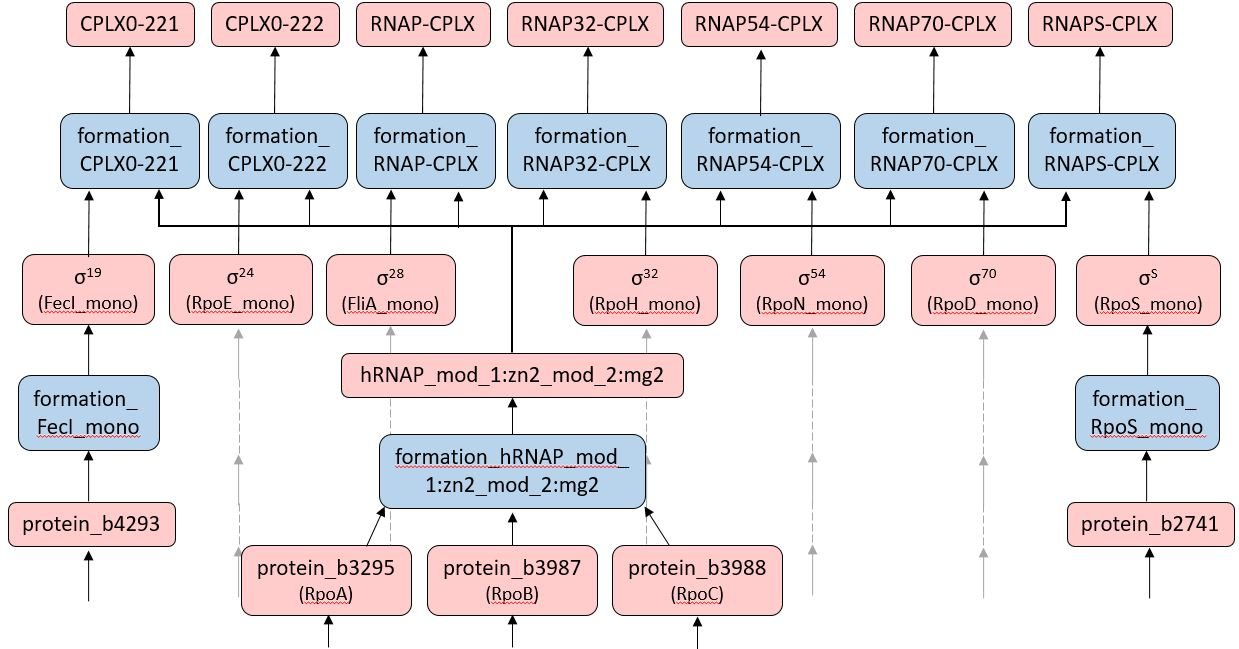

The role of the other potential transcription reaction support metabolites are listed below

1. **Mfd_mono_mod_1:mg2:** *transcription-repair coupling factor*
   - The Mfd protein, also known as transcription-repair coupling factor (TRCF), is responsible for ATP-dependent displacement of stalled RNA polymerase (RNAP) from DNA lesions. 
   - Mfd facilitates the repair of template strand lesions. 
   - See https://ecocyc.org/gene?orgid=ECOLI&id=EG11619
  
  
2. **NusA_mono:** *transcription termination/antitermination protein NusA*
    - Transcription termination/antitermination L factor (NusA) is a key component in both prevention and enhancement of transcriptional termination. 
    - It is important in both Rho-dependent and intrinsic termination, as well as in lambda and other phage antitermination systems. 
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10665
    
3. **NusB_mono:** *transcription antitermination protein NusB*
    - Transcription antitermination protein NusB is involved in antitermination in the transcription of a number of genes. In particular, NusB is required for proper transcription of the ribosomal RNA (rRNA) genes.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10666
       
4. **NusG_mono:** *transcription termination/antitermination factor NusG*
    - Transcription termination factor NusG is required for some kinds of Rho-dependent termination as well as for transcription antitermination.NusG is also involved in antitermination during lambda phage transcription     
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10667
    
    
5. **GreA_mono:** *transcription elongation factor GreA*
    - GreA stimulates the mRNA cleavage activity of RNA polymerase, which acts to release a polymerase complex that has stalled or has incorporated an incorrect nucleotide. 
    - GreA (and GreB) is also required for wild-type transcription of some regulatory regions within lambda phage. 
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10415
    
6. **Nucleotides:** Nucleotides required for RNA production
    - atp_c, ctp_c, gtp_c, utp_c

7. **GreB_mono:** *transcription elongation factor GreB*
    - GreB stimulates the mRNA cleavage activity of RNA polymerase, which acts to release a polymerase complex that has stalled. 
    - GreB (and GreA) is also required for wild-type transcription of some regulatory regions within lambda phage. 
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG11578

8. **monocistronic_excision_machinery:** *Processing of monocistronic mRNA*
    - Constructed from the following metabolites by "formation_monocistronic_excision_machinery" reaction: RNase_E_tetra_mod_2:zn2, RNase_P_cplx_mod_2:mg2, and generic_RNase.

9. **polycistronic_wout_rRNA_excision_machinery:** *Processing of polyocistronic mRNA*
    - Constructed from the following metabolites by "formation_polycistronic_wout_rRNA_excision_machinery" reaction: RNase_E_tetra_mod_2:zn2, RNase_P_cplx_mod_2:mg2, generic_RNase, RNase_III_dim, RNase_G_dim, and RNase_T_dim_mod_4:mg2.

10. **Rho_hexa_mod_3:mg2:** *transcription termination factor Rho*
    - Rho is required for one of the two major types of termination of RNA transcription.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10845

11. **RplC_mono:** *50S ribosomal subunit protein L3*
    - The L3 protein is a component of the 50S subunit of the ribosome. L3 and L24 are the two proteins that initiate assembly of the 50S subunit
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10866

12. **RNA_degradosome:** *multiprotein complex involved in RNA degradation*
    - The degradosome is a large, multiprotein complex involved in RNA degradation
    - Constructed from the following metabolites by formation_RNA_degradosome: Eno_dim_mod_4:mg2, Pnp_trim, RNase_E_tetra_mod_2:zn2, RhlB_dim, and Orn_dim_mod_2:mg2.
    - See https://www.ecocyc.org/ECOLI/NEW-IMAGE?type=ENZYME&object=CPLX0-2381

13. **RplD_mono:** *50S ribosomal subunit protein L4*
    - The L4 protein is a component of the 50S subunit of the ribosome and also regulates the expression of S10 operon at both the transcriptional and posttranscriptional level. The functions of L4 in ribosome assembly, attenuation, and translational regulation of the operon are separable
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10867

14. **RplM_mono:** *50S ribosomal subunit protein L13*
    - The L13 protein is an early assembly component of the 50S subunit of the ribosome
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10874

15. **RpoZ_mono_mod_1:mg2:** *RNA polymerase subunit ω*
    - RpoZ copurifies with RNA polymerase and may play a structural role in that complex.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10899
    
16. **RpsD_mono:** *30S ribosomal subunit protein S4*
    - The S4 protein, a component of the 30S subunit of the ribosome, functions in the assembly of the 30S ribosomal subunit, the mRNA helicase activity of the ribosome, the regulation of translation of a subset of ribosomal proteins, and transcription antitermination of rRNA operons.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10903

17. **RpsJ_mono:** *30S ribosomal subunit protein S10*
    - The S10 protein (NusE) is a component of the 30S subunit of the ribosome. From within its location in the ribosome, S10 plays a role in linking transcription and translation; in a separate complex with NusB, it plays a role in regulating transcription antitermination.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10909
    
18. **rRNA_containing_excision_machinery:** *processing of rRNA*
    - Constructed from the following metabolites by "formation_rRNA_containing_excision_machinery" reaction: RNase_E_tetra_mod_2:zn2, RNase_P_cplx_mod_2:mg2, generic_RNase, RNase_m5, RNase_m16, RNase_m23, RNase_III_dim_mod_2:mg2, RNase_G_dim>, and RNase_T_dim_mod_4:mg2.

## 5. Example of iJL1678b-ME (ECOLIme) "TranscriptionReaction"
Let's begin by looking at the required reactants and products of "TranscriptionReactions". We will use the reactions "transcription_TU0_13350_from_RpoD_mono" which corresponds to b1623 or "add" (adenosine deaminase) as our example.

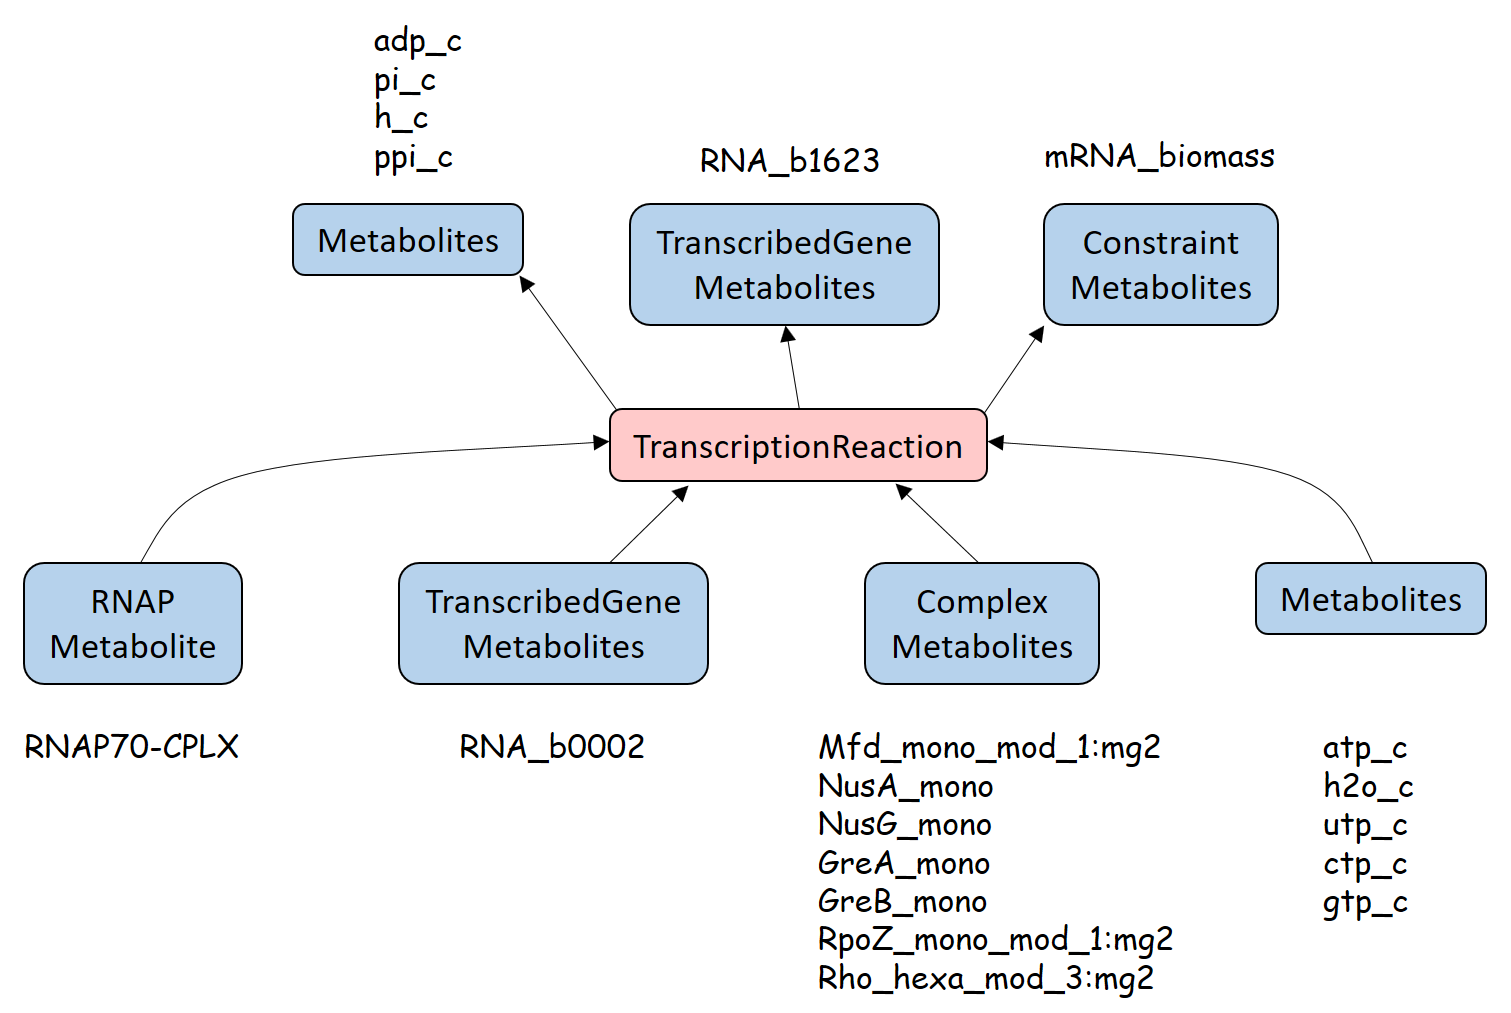

The "RpoD_mono" at the end of the "TranscriptionReaction" name implies that the RNAP70-CPLX is used by this "TranscriptionReaction". The other suffixes used by "TranscriptionReactions" are listed below.

- EG11355_MONOMER -> CPLX0-222 ($\sigma$<sup>28</sup>)
- FecI_mono -> CPLX0-221 ($\sigma$<sup>19</sup>)
- RpoD_mono -> RNAP70-CPLX ($\sigma$<sup>70</sup>)
- RpoE_MONOMER -> RNAPE-CPLX ($\sigma$<sup>24</sup>)
- RpoH_MONOMER -> RNAP32-CPLX ($\sigma$<sup>32</sup>)
- RpoN_MONOMER -> RNAP54-CPLX ($\sigma$<sup>54</sup>)
- RpoS_MONOMER -> RNAP70-CPLX ($\sigma$<sup>S</sup>)

The role of the "Complex" metabolites is givein below.

1. **Mfd_mono_mod_1:mg2:** *transcription-repair coupling factor*
   - The Mfd protein, also known as transcription-repair coupling factor (TRCF), is responsible for ATP-dependent displacement of stalled RNA polymerase (RNAP) from DNA lesions. 
   - Mfd facilitates the repair of template strand lesions. 
   - See https://ecocyc.org/gene?orgid=ECOLI&id=EG11619
  
  
2. **NusA_mono:** *transcription termination/antitermination protein NusA*
    - Transcription termination/antitermination L factor (NusA) is a key component in both prevention and enhancement of transcriptional termination. 
    - It is important in both Rho-dependent and intrinsic termination, as well as in lambda and other phage antitermination systems. 
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10665
    
    
3. **NusG_mono:** *transcription termination/antitermination factor NusG*
    - Transcription termination factor NusG is required for some kinds of Rho-dependent termination as well as for transcription antitermination.NusG is also involved in antitermination during lambda phage transcription     
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10667
    
    
4. **GreA_mono:** *transcription elongation factor GreA*
    - GreA stimulates the mRNA cleavage activity of RNA polymerase, which acts to release a polymerase complex that has stalled or has incorporated an incorrect nucleotide. 
    - GreA (and GreB) is also required for wild-type transcription of some regulatory regions within lambda phage. 
    - See https://ecocyc.org/gene?orgid=ECOLI&id=EG10415
    
    
5. **GreB_mono:** *transcription elongation factor GreB*
    - GreB stimulates the mRNA cleavage activity of RNA polymerase, which acts to release a polymerase complex that has stalled. 
    - GreB (and GreA) is also required for wild-type transcription of some regulatory regions within lambda phage. 
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG11578
    
    
6. **RpoZ_mono_mod_1:mg2:** *RNA polymerase subunit ω*
    - RpoZ copurifies with RNA polymerase and may play a structural role in that complex.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10899
    
    
7. **Rho_hexa_mod_3:mg2:** *transcription termination factor Rho*
    - Rho is required for one of the two major types of termination of RNA transcription.
    - See https://www.ecocyc.org/gene?orgid=ECOLI&id=EG10845


List the products of the transcription reaction

In [8]:
me.reactions.get_by_id('transcription_TU0_13350_from_RpoD_mono').products

[<TranscribedGene RNA_b1623 at 0x7fd1b29485f8>,
 <Metabolite adp_c at 0x7fd1b2948b38>,
 <Metabolite pi_c at 0x7fd1b2948c18>,
 <Metabolite h_c at 0x7fd1b2948cf8>,
 <Metabolite ppi_c at 0x7fd1b29510b8>,
 <Constraint mRNA_biomass at 0x7fd1b2a680b8>]

List the reactants of the transcription reaction

In [9]:
me.reactions.get_by_id('transcription_TU0_13350_from_RpoD_mono').reactants

[<RNAP RNAP70-CPLX at 0x7fd1b2948358>,
 <Complex Mfd_mono_mod_1:mg2 at 0x7fd1b29486a0>,
 <Complex NusA_mono at 0x7fd1b29486d8>,
 <Complex NusG_mono at 0x7fd1b29487b8>,
 <Complex GreA_mono at 0x7fd1b29487f0>,
 <Complex GreB_mono at 0x7fd1b2948828>,
 <Complex RpoZ_mono_mod_1:mg2 at 0x7fd1b2948860>,
 <Complex Rho_hexa_mod_3:mg2 at 0x7fd1b29488d0>,
 <Metabolite atp_c at 0x7fd1b2948940>,
 <Metabolite h2o_c at 0x7fd1b2948a20>,
 <Metabolite utp_c at 0x7fd1b2948dd8>,
 <Metabolite ctp_c at 0x7fd1b2948eb8>,
 <Metabolite gtp_c at 0x7fd1b2948f98>]

List the reaction associated with the transcription reaction

In [10]:
me.reactions.get_by_id('transcription_TU0_13350_from_RpoD_mono').reaction

'4.27350427350427e-6*mu GreA_mono + 4.27350427350427e-6*mu GreB_mono + 4.27350427350427e-6*mu Mfd_mono_mod_1:mg2 + 4.27350427350427e-6*mu NusA_mono + 4.27350427350427e-6*mu NusG_mono + 0.00478843159746119*mu + 0.00187467097040606 RNAP70-CPLX + 4.27350427350427e-6*mu Rho_hexa_mod_3:mg2 + 4.27350427350427e-6*mu RpoZ_mono_mod_1:mg2 + 239.0 atp_c + 266 ctp_c + 274 gtp_c + 3.0 h2o_c + 226 utp_c --> RNA_b1623 + 3.0 adp_c + 3.0 h_c + 321.640635962 mRNA_biomass + 3.0 pi_c + 1002 ppi_c'

List the fluxes flowing through all the transcription reactions

In [11]:
transcription_reactions = []
transcription_reaction_flux = []
x = [r.id for r in me.reactions]
for r in x:
    if 'transcription_T' in r:
        transcription_reactions.append(r)
        transcription_reaction_flux.append(me.reactions.get_by_id(r).x)

# Create Pandas table
zipped = list(zip(transcription_reactions, transcription_reaction_flux))
df = pd.DataFrame(zipped, columns=['Transcription Reactions', 'Transcription Reaction Flux']).set_index('Transcription Reactions')
df = df.loc[~(df==0).all(axis=1)] # removing reactions with zero flux
df

,Transcription Reaction Flux
Transcription Reactions,
transcription_TU0_8529_from_RpoD_mono,1.136100e-11
transcription_TU0_8464_from_RpoD_mono,2.302526e-06
transcription_TU0_13006_from_RpoD_mono,3.244344e-14
transcription_TU0_5003_from_RPOH_MONOMER,2.728023e-10
transcription_TU0_3423_from_RPOE_MONOMER,3.448065e-08
transcription_TU00429_from_RpoD_mono,1.707059e-08
transcription_TU00293_from_RpoD_mono,8.921349e-11
transcription_TU0_3424_from_RPOE_MONOMER,6.515644e-08
transcription_TU00369_from_RpoD_mono,2.109657e-11


List the fluxes through the transcription reactions based on the locus number of reaction's genes.

In [12]:
me.get_transcription_flux()

{'b1623': 0.0,
 'b0516': 0.0,
 'b0517': 0.0,
 'b1109': 0.0,
 'b1744': 0.0,
 'b1745': 0.0,
 'b1748': 0.0,
 'b1747': 0.0,
 'b1746': 0.0,
 'b0343': 0.0,
 'b0344': 0.0,
 'b2378': 0.0,
 'b4258': 1.2028154810349738e-08,
 'b0149': 0.0,
 'b1676': 0.0,
 'b0029': 9.050032077239047e-09,
 'b0027': 9.050032077239047e-09,
 'b0423': 1.136100187771812e-11,
 'b0842': 0.0,
 'b3174': 1.0507929305222555e-05,
 'b3175': 1.3661971707623725e-07,
 'b4055': 0.0,
 'b1977': 0.0,
 'b0871': 0.0,
 'b0870': 0.0,
 'b3986': 3.070034645932994e-06,
 'b1907': 0.0,
 'b0630': 3.244344439354157e-14,
 'b0459': 0.0,
 'b4388': 4.057924763210627e-09,
 'b2146': 0.0,
 'b2147': 0.0,
 'b1519': 0.0,
 'b4122': 0.0,
 'b4142': 2.728022741929614e-10,
 'b4143': 2.728022741929614e-10,
 'b3063': 0.0,
 'b3062': 0.0,
 'b3061': 0.0,
 'b3610': 0.0,
 'b0957': 0.0,
 'b0155': 0.0,
 'b2617': 3.448064683464188e-08,
 'b1986': 0.0,
 'b3732': 4.86138369497595e-06,
 'b3738': 4.86138369497595e-06,
 'b3735': 4.86138369497595e-06,
 'b3734': 4.8613836949759